<a href="https://colab.research.google.com/github/racoonon/2024_OUTTA/blob/main/%EC%8B%A4%EC%8A%B52_1_%EC%9E%90%EB%8F%99%EB%AF%B8%EB%B6%84_%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실습 3: 자동미분(AutoDiff) 라이브러리

앞서 우리는 그래디언트 기반 학습에 대해 살펴보았다. $\mathscr{L}$이 간단한 함수일 때는 편미분하는 것이 간단한 일이었지만, 앞으로는 손으로 편미분을 계산하기는 어려운 다양한 함수들을 $\mathscr{L}$ 로 만나게 될 것이다. 이럴 때 필요한 것이 바로 컴퓨터의 계산 능력이다. 그래디언트 기반 학습에 대한 관심이 크게 증가하면서, 미분을 자동으로 계산해주는 자동미분 라이브러리가 여럿 개발되었다. 널리 쓰이는 라이브러리로는 [PyTorch](https://pytorch.org/), [TensorFlow](https://www.tensorflow.org/), [JAX](https://github.com/google/jax), [Zygote](https://github.com/FluxML/Zygote.jl) 등이 있다.

이 책에서는 위의 라이브러리 중에서 쉽게 이해하고 사용할 수 있는 PyTorch 라이브러리를 사용할 것이다. 이 라이브러리는 NumPy 라이브러리와 매우 유사하게 동작하기 때문에, NumPy만 잘 알아도 쉽게 사용할 수 있다. NumPy에서 ndarray(배열)가 기본이 되는 핵심 객체인 것과 같이, PyTorch의 핵심 객체는 Tensor(텐서)라고 부른다. 이 Tensor는 ndarray와 매우 유사하게 동작이 가능하다.

이 실습에서 PyTorch를 통한 자동미분에 익숙해지고 나면, 이 책 전반에 걸쳐 PyTorch를 자유자재로 사용하며 딥러닝을 배우게 될 것이다.

In [ ]:
import torch
import torch as tc
import numpy as np

구글 코랩(Google Colab)에서는 PyTorch가 기본적으로 설치되어 있다. 따라서 별도로 설치할 필요 없이 바로 사용 가능하다. PyTorch가 제대로 설치되어 있는지 확인하려면 아래와 같은 코드를 실행해볼 수 있다.
torch.cuda.is_available() 코드가 False의 결과가 나오면 메뉴에서

런타임 > 런타임 유형 변경 > 하드웨어 가속기

에서 보면 CPU가 선택되어 있을 것인데 이를 GPU로 바꿔줘야 한다.

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
# cuda는 gpu를 실행할 수 있도록 하는 일종의 플랫

2.3.0+cu121
False


### Step 1. PyTorch의 여러가지 함수

라이브러리를 사용할 때, 유명한 라이브러리의 경우에는 구글링을 통해 쉽게 설명된 블로그 등을 참고할 수도 있다. 하지만 정석은 라이브러리 개발자가 작성한 도큐먼트(document)를 읽는 것이다. 이 실습에서는 PyTorch를 사용한 자동미분을 배우는 것을 가장 중요한 목적으로 다루고 있으므로, 더 다양한 함수와 기능이 궁금하다면 직접 [도큐먼트](https://mygrad.readthedocs.io/en/latest/)를 읽어보길 바란다. 또한, NumPy의 기본 함수들과 일치하는 함수를 많이 가지고 있으므로, NumPy의 함수들을 찾아 PyTorch에 적용해보아도 좋다.

#### Tensor 생성
Tensor는 Pytorch 라이브러리에서 사용하는 데이터를 배열 형식으로 저장하도록 한다. 다양한 방식으로 Tensor를 생성할 수 있다. 다음은 Tensor를 생성하는 여러 가지 예이다. tc.tensor 외에도 Tensor를 생성하는 다양한 함수들이 있다. 직접 코드를 실행하여 output을 확인해보자.

In [ ]:
# 단일 숫자로 생성한 Tensor
tc.tensor(2.3)

tensor(2.3000)

In [ ]:
# 시퀀스(리스트, 튜플 등) 자료형으로 생성한 Tensor.
# dtype을 지정할 수 있는 모든 함수에서
# 32-bit floats를 저장하는 텐서를 반환하도록 지정 가능.
tc.tensor([1.0, 2.0, 3.0], dtype=tc.float32)

tensor([1., 2., 3.])

In [ ]:
# numpy.ndarray로부터 생성한 Tensor
# np.ones 함수는 shape 인자를 튜플 형식으로 받아야함
arr = np.ones((3, 3))
# numpy로 받은 arr을 간단하게 tensor로 변환 가능
tc.tensor(arr)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)

In [ ]:
# Tensor 생성 함수 (ones, zeros; 각각 1, 0으로 채움)
tc.zeros((2,3,4))

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

In [ ]:
# Tensor 생성 함수 (start 부터 stop 까지 step 만큼 띄워가며 채움)
# 시작, 끝, 보폭 (끝 포함x)
tc.arange(-5, 15, 2)

tensor([-5, -3, -1,  1,  3,  5,  7,  9, 11, 13])

In [ ]:
# start = 0, step = 1이 default 값
# 9 vs 9.
tc.arange(9.)

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8.])

In [ ]:
# 0~1 사이의 값 무작위로 리턴 (확률분포는 균등분포(uniform))
tc.rand(3, 4)

tensor([[0.8073, 0.1914, 0.7205, 0.7292],
        [0.8768, 0.4514, 0.4284, 0.2526],
        [0.1022, 0.8586, 0.6412, 0.7775]])

<문제: 주어진 조건을 만족하는 Tensor 생성하기>

구간 $[0, \pi]$에 등간격으로 분포한 15개의 구성요소로 이루어진 shape-(15,)인 tensor를 만들어보자. (Hint: tc.linspace(), tc.pi)

In [ ]:
# 여기에 코드 작성
# 시작, 끝, 등분수 (시작과 끝 포함 => /14가 )
tc.linspace(0, tc.pi, 15)

tensor([0.0000, 0.2244, 0.4488, 0.6732, 0.8976, 1.1220, 1.3464, 1.5708, 1.7952,
        2.0196, 2.2440, 2.4684, 2.6928, 2.9172, 3.1416])

#### Tensor 변형
Tensor의 모양을 변형하는 함수들도 있다. 직접 코드를 실행하여 output을 확인해보자.

In [ ]:
# Tensor의 행과 열을 바꾸어주는 함수
x = tc.arange(9.) #Tensor([0., 1., 2., 3., 4., 5., 6., 7., 8.])
x.reshape(3,3)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [ ]:
# Tensor의 전치 행렬을 구하는 함수
x = tc.tensor([[0,1,2], [3,4,5],[6,7,8],[9,10,11]])
x.t()

tensor([[ 0,  3,  6,  9],
        [ 1,  4,  7, 10],
        [ 2,  5,  8, 11]])

In [ ]:
# 슬라이싱 (자유자재로 쓸 수 있으면 좋다)
x = tc.tensor([[1,2,3,4,5],[6,7,8,9,10]])
# 가장 첫 번째의 행의 세번째 원소부터
x[0, 2:]

tensor([3, 4, 5])

In [ ]:
x = tc.tensor([[1,2,3,4,5],[6,7,8,9,10]])
x[0, -3:]

tensor([3, 4, 5])

#### Tensor 표준 수학 연산

먼저, PyTorch에서 제공하는 표준적인 수학 함수들을 알아보자. 기본적인 산술 연산을 하는 함수를 비롯하여, (sum, mean, var, std, max, min) 등의 통계량을 구하는 함수 등이 제공된다. 또한, 삼각함수, 쌍곡함수, 지수함수, 로그함수 등의 초월함수도 제공된다. NumPy의 함수들과 동일하게, 벡터화된 함수들이다.

단항 함수는 텐서에 대해 요소별로 각각 작동한다. 이항 함수는 두 텐서에 대해 대응되는 위치의 요소 간에 자연스럽게 작동한다. 두 텐서가 동일한 모양이 아니더라도 Numpy와 같은 [브로드캐스팅(Broadcasting)](https://numpy.org/doc/stable/user/basics.broadcasting.html) 규칙을 따르기 때문에, 이항 함수가 작동할 수 있는 경우가 있다.

직접 코드를 실행하여 output을 확인해보자. 이를 통해 단항 연산과 이항 연산을 다루는 여러 함수에 대해 이해해보자.

In [ ]:
x = tc.tensor([0.0, 0.25, 0.5, 0.75, 1.0]) # 1*5
y = tc.tensor([[0.],[1.],[2.]]) # 3*1
z = tc.tensor([[0,1,2,3],[4,5,6,7],[8,9,10,11]]) # 3*4

In [ ]:
# 단항 함수 중 하나인 삼각함수 sin()
# 텐서의 모든 요소의 sin 값으로 채워진 같은 크기의 텐서
tc.sin(x)

tensor([0.0000, 0.2474, 0.4794, 0.6816, 0.8415])

In [ ]:
# 단항 함수 중 통계량을 구하는 함수들은 axis 인자를 가짐
# axis가 0이면 행에 대해서만 함수를 적용하고,
# axis가 1이면 열에 대해서만 함수를 적용
tc.sum(z)

tensor(66)

In [ ]:
tc.sum(z, axis=0)

tensor([12, 15, 18, 21])

z = tc.tensor([[0,1,2,3],[4,5,6,7],[8,9,10,11]])

=>

$[[0,1,2,3], \\
    [4,5,6,7], \\
    [8,9,10,11]]$

In [ ]:
tc.sum(z, axis=1)

tensor([ 6, 22, 38])

In [ ]:
# 브로드캐스팅 예(1)
# 크기가 작은 텐서가 크기가 큰 텐서에 맞춰서 작
# x+y, y+z는 브로드캐스팅이 가능, x+z는 불가능
x+y # 3*5

tensor([[0.0000, 0.2500, 0.5000, 0.7500, 1.0000],
        [1.0000, 1.2500, 1.5000, 1.7500, 2.0000],
        [2.0000, 2.2500, 2.5000, 2.7500, 3.0000]])

In [ ]:
y+z # 3*4

tensor([[ 0.,  1.,  2.,  3.],
        [ 5.,  6.,  7.,  8.],
        [10., 11., 12., 13.]])

In [ ]:
x+z # Error 발생

RuntimeError: The size of tensor a (5) must match the size of tensor b (4) at non-singleton dimension 1

In [ ]:
# 브로드캐스팅 예(2)
# x*y, y*z는 브로드캐스팅이 가능, x*z는 불가능
x*y

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2500, 0.5000, 0.7500, 1.0000],
        [0.0000, 0.5000, 1.0000, 1.5000, 2.0000]])

In [ ]:
y*z

tensor([[ 0.,  0.,  0.,  0.],
        [ 4.,  5.,  6.,  7.],
        [16., 18., 20., 22.]])

In [ ]:
x*z # Error 발생

RuntimeError: The size of tensor a (5) must match the size of tensor b (4) at non-singleton dimension 1

<문제: Pytorch의 기본 수학 연산>

아래와 같이 정의된 텐서 x에 대해 여러 가지 수학 연산을 적용하여 여러 가지 텐서를 구해보자.

In [ ]:
x = tc.Tensor([[ 0.,  1.,  2.,  3.],
...                [ 4.,  5.,  6.,  7.],
...                [ 8.,  9., 10., 11.],
...                [12., 13., 14., 15.]])

## 1번 문제

1. x의 3행의 첫번째, 세번째 원소에 대한 자연로그 값으로 채워진 shape-(2,)인 Tensor를 구해보자.

In [ ]:
# 여기에 코드 작성
tc.log(x[2,0::2])

tensor([2.0794, 2.3026])

## 1번 문제 정답

In [ ]:
tc.log(x[2,0::2])

1번 문제 출력 결과 : tensor([2.0794, 2.3026])

# 2번 문제

2. x를 가로, 세로로 4등분한 각 귀퉁이(왼쪽 위, 오른쪽 위, 왼쪽 아래, 오른쪽 아래)의 4개 원소를 더하여 shape-(2,2)인 Tensor를 구해보자.

In [ ]:
# 여기에 코드 작성
# x를 2*2 sub tensor로 나눈 후 합
x[:2,:2] + x[:2,2:] + x[2:,:2] + x[2:,2:]

tensor([[20., 24.],
        [36., 40.]])

## 2번 문제 정답

In [ ]:
x[:2,:2] + x[:2,2:] + x[2:,:2] + x[2:,2:]

2번 문제 출력 결과 :

tensor([[20., 24.],\
        [36., 40.]])

## 3번 문제

  3. x의 각 열의 평균을 구하여 shape-(4,)인 Tensor를 구해보자.

In [ ]:
# 여기에 코드 작성
# 행을 따라 평균 계산
tc.mean(x, dim=0)

tensor([6., 7., 8., 9.])

## 3번 문제 정답

In [ ]:
x.mean(axis=0)

3번 문제 출력 결과 : tensor([6., 7., 8., 9.])

# 4번 문제

4. x의 각 행을 벡터로보고, 각 벡터가 크기가 1이 되도록 정규화하여 shape-(4,4)인 Tensor로 업데이트해보자.

In [ ]:
# 여기에 코드 작성
norms = x.norm(p=2, dim=1, keepdim=True)
x /= norms
x

tensor([[0.0000, 0.2673, 0.5345, 0.8018],
        [0.3563, 0.4454, 0.5345, 0.6236],
        [0.4182, 0.4704, 0.5227, 0.5750],
        [0.4429, 0.4798, 0.5167, 0.5537]])

In [ ]:
# 정규화가 잘 되었는지 확인하기
tc.sum(x**2, axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000])

## 4번 문제 정답

In [ ]:
x /= tc.sqrt(tc.sum(x**2,axis=1,keepdims = True))
x

4번 문제 출력 결과 : \\

tensor([[0.0000, 0.2673, 0.5345, 0.8018], \
        [0.3563, 0.4454, 0.5345, 0.6236], \
        [0.4182, 0.4704, 0.5227, 0.5750], \
        [0.4429, 0.4798, 0.5167, 0.5537]])

In [ ]:
# 정규화가 잘 되었는지 확인하기 정답
(x**2).sum(axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000])

#   

#### 선형대수 연산 함수

PyTorch에는 선형대수 연산을 쉽게 계산하도록 도와주는 함수들도 있다. matmul()은 행렬곱을 계산해주는 함수이다. 이를 이용하여 벡터의 점곱(스칼라곱)을 계산할 수도 있다. einsum()은 아인슈타인 표기법(Einstein notation 또는 Einstein summation convention)을 계산하는 함수이다. 이는 다소 복잡한 함수이지만, 다양한 사용자 지정 가능한 선형 대수 연산을 수행할 수 있다. PyTorch가 자동미분을 수행할 때 이 연산들을 통해 수행한다.

먼저 이항 연산 함수인 matmul()연산은 행렬곱을 기본으로 하는 함수이므로 2차원 텐서 간의 연산이 가장 자연스럽게 정의된다. 1차원 텐서 간의 matmul()을 명령하면 1차원 텐서를 1xn 크기의 2차원 텐서로 생각하여 연산을 진행한다. 그리고 n차원(3차원 이상)의 텐서 간의 matmul()은 n-2차원의 텐서의 구성요소가 2차원 텐서(행렬)인 것으로 생각하여 연산을 진행한다. 즉, 행렬이 여러개 모여있는 것으로 생각하고 행렬곱을 진행하는 것이다. matmul()연산 또한 NumPy의 브로드캐스팅 규칙을 따르는 함수이기 때문에 3차원 이상의 텐서에 대해서는 브로드캐스팅에도 유의해야 한다.

matmul()을 사용할 때는 tc.matmul(x,y)로 사용할 수 있지만, x @ y 와 같이 연산자 @를 이용하여도 같은 연산을 할 수 있도록 정의되어 있다. 아래의 사용 예시를 따라가면 matmul() 함수의 사용법을 이해할 수 있을 것이다. 직접 코드를 실행하여 output을 확인해보자.

In [ ]:
# 1차원 텐서의 matmul 연산은 점곱(스칼라곱)을 구하는 것과 같음
x = tc.tensor([1.0, 2.0])
y = tc.tensor([-3.0, -4.0])
tc.matmul(x, y)

tensor(-11.)

In [ ]:
# 1차원 텐서의 matmul 연산은 점곱(스칼라곱)을 구하는 것과 같음
x = tc.tensor([1.0, 2.0])
y = tc.tensor([-3.0, -4.0])
x @ y

tensor(-11.)

In [ ]:
# 2차원 텐서의 matmul 연산은 그냥 행렬곱과 같음
a = tc.tensor([[1, 0], [0, 1], [2, 1], [3, 4]]) # 4*2
b = tc.tensor([[4, 1, 5], [2, 2, 6]]) # 2*3
tc.matmul(a, b) # a @ b ; 4*3

tensor([[ 4,  1,  5],
        [ 2,  2,  6],
        [10,  4, 16],
        [20, 11, 39]])

In [ ]:
# A는 크기가 (4, 2, 3)인 3차원 텐서
# 2*3=6이 stop
A1 = tc.arange(2*3).reshape((2,3))
A = tc.stack([A1, A1+2, A1+4, A1+6])

# B는 크기가 (4, 3, 3)인 3차원 텐서
B1 = tc.arange(3*3).reshape((3,3))
B = tc.stack([B1, B1+2, B1+4, B1+6])

# matmul 연산을 제대로 이해했는지 확인하기 위해
# 손으로도 직접 계산해보고, 결과가 동일한지 확인해보기
print(A)
print(B)
print(tc.matmul(A, B))

tensor([[[ 0,  1,  2],
         [ 3,  4,  5]],

        [[ 2,  3,  4],
         [ 5,  6,  7]],

        [[ 4,  5,  6],
         [ 7,  8,  9]],

        [[ 6,  7,  8],
         [ 9, 10, 11]]])
tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8]],

        [[ 2,  3,  4],
         [ 5,  6,  7],
         [ 8,  9, 10]],

        [[ 4,  5,  6],
         [ 7,  8,  9],
         [10, 11, 12]],

        [[ 6,  7,  8],
         [ 9, 10, 11],
         [12, 13, 14]]])
tensor([[[ 15,  18,  21],
         [ 42,  54,  66]],

        [[ 51,  60,  69],
         [ 96, 114, 132]],

        [[111, 126, 141],
         [174, 198, 222]],

        [[195, 216, 237],
         [276, 306, 336]]])


In [ ]:
C = tc.matmul(A, B)
print(C.shape) # .shape 많이 쓰임; 어떤 tensor 모양인지
print(C)

torch.Size([4, 2, 3])
tensor([[[ 15,  18,  21],
         [ 42,  54,  66]],

        [[ 51,  60,  69],
         [ 96, 114, 132]],

        [[111, 126, 141],
         [174, 198, 222]],

        [[195, 216, 237],
         [276, 306, 336]]])


In [ ]:
# 브로드캐스팅 예 (y를 5개로 브로드캐스팅하여 x와 연산)
x = tc.rand(5,3,4)
y = tc.rand(4,2)
tc.matmul(x,y) # x @ y ; 5*3*2

tensor([[[0.8837, 0.8812],
         [1.1328, 0.5588],
         [0.5951, 0.2861]],

        [[0.8660, 0.7786],
         [0.6128, 0.4270],
         [1.0933, 0.7368]],

        [[0.9714, 1.0108],
         [1.6162, 1.2815],
         [1.3230, 0.9404]],

        [[0.5928, 0.8220],
         [1.3836, 0.8073],
         [1.3041, 0.8912]],

        [[1.5261, 0.7164],
         [1.0842, 0.7850],
         [1.0134, 0.5427]]])

NumPy에서는 행렬곱 연산을 하는 함수가 두 개 있다. 바로 dot연산과 matmul 연산이다.두 함수는 2차원 배열 두개의 곱에 대해 동일한 행렬곱을 결과로 도출한다. 그러나 3차원 이상에서는 서로 다르게 동작한다. 이 두 함수의 차이가 궁금하다면 직접 검색하여 공부해보자.

다음으로 einsum()함수는 행렬 연산에 관한 다양한 함수들을 다 알지 못하더라도, 이 함수 하나만을 가지고 다양한 행렬 연산을 사용자가 직접 지정해줄 수 있는 함수이다. 이 함수의 원리는 아인슈타인 표기법을 따르는데, 아인슈타인 표기법에 대해 스스로 검색하여 공부해보면 Numpy와 PyTorch에서 einsum()함수를 사용하는 예시들을 쉽게 이해할 수 있을 것이다.

아래의 예시들을 직접 실행해보며 einsum()함수의 유용함을 느껴보자, einsum()함수에 대해 완벽히 이해하지 못했더라도 괜찮다. 다만 앞으로 einsum()함수의 새로운 사용 예시를 보게 되더라도 낯설고 어렵게 느끼지 말고, 익숙하게 느끼길 바란다.

In [ ]:
a = tc.arange(25).reshape(5,5)
b = tc.arange(15).reshape(5,3)
c = -tc.arange(15).reshape(5,3)
a, b, c

(tensor([[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14],
         [15, 16, 17, 18, 19],
         [20, 21, 22, 23, 24]]),
 tensor([[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8],
         [ 9, 10, 11],
         [12, 13, 14]]),
 tensor([[  0,  -1,  -2],
         [ -3,  -4,  -5],
         [ -6,  -7,  -8],
         [ -9, -10, -11],
         [-12, -13, -14]]))

i는 행, j는 열을 뜻함


In [ ]:
# a의 대각합
tc.einsum("ii", a)

tensor(60)

In [ ]:
# a의 대각원소
tc.einsum('ii->i',a)

tensor([ 0,  6, 12, 18, 24])

In [ ]:
# b의 전치행렬
tc.einsum('ji',b)

tensor([[ 0,  3,  6,  9, 12],
        [ 1,  4,  7, 10, 13],
        [ 2,  5,  8, 11, 14]])

In [ ]:
# a와 b의 행렬곱 계산 (matmul과 결과가 동일함을 확인해보기)
tc.einsum('ij,jk->ik',a,b), tc.matmul(a,b)

(tensor([[ 90, 100, 110],
         [240, 275, 310],
         [390, 450, 510],
         [540, 625, 710],
         [690, 800, 910]]),
 tensor([[ 90, 100, 110],
         [240, 275, 310],
         [390, 450, 510],
         [540, 625, 710],
         [690, 800, 910]]))

In [ ]:
# 같은 모양의 텐서 b,c의 각 행끼리의 점곱을 계산
tc.einsum("ij,ij->i",b,c)

tensor([  -5,  -50, -149, -302, -509])

#### 자동미분과 딥러닝을 위한 특수 함수

PyTorch는 NumPy와 유사한 함수들 외에도 PyTorch만의 딥러닝을 위한 특수 함수들을 제공합니다. torch.nn 모듈에서는 딥러닝을 진행할 신경망을 구현하는 데 필요한 손실 함수(loss function), 활성 함수(activation function), 초기화 함수(initializer)의 대표적인 예시들을 제공합니다. 이러한 함수들에 대해서는 이번 실습에서는 다루지 않을 것이지만, 바로 다음 실습부터 꾸준히 여러 함수들이 등장할 예정입니다.

### Step 2 자동미분 실행하기

이제 PyTorch 라이브러리의 핵심 기능인 자동미분에 대해 알아보자. PyTorch를 비롯한 대부분의 자동미분 라이브러리는 함수의 도함수(편도함수)를 직접 구하지 않는다. 그 대신 주어진 점(입력값)에서의 미분계수(편미분계수) 값을 구한다. 즉, 자동미분 라이브러리는 지정해준 점에서의 함수의 순간 기울기를 구하는 기능만을 갖고 있으며, 우리는 이를 이용하여 미분가능한 모든 함수의 모든 지점에서의 기울기를 구할 수 있다.

#### 텐서 객체의 '.backward()' 메서드

PyTorch에서 자동미분을 호출하기 위해 필요한 유일한 방법은 Tensor.backward()이다. 다른 텐서로부터 계산한 텐서 F에 대해 F.backward()를 호출하면, PyTorch는 F가 의존하는 모든 텐서에 대해 F의 편미분계수를 계산하도록 지시한다. 이 편미분계수들은 각각의 텐서들의 .grad 속성에 Tensor로 저장된다. 이때 몇 가지 주의사항이 있다.

1. requires_grad=True:
자동 미분을 추적하려면 텐서를 생성할 때 requires_grad=True로 설정해야 한다.

2. backward() 호출:
Tensor.backward()를 호출하면 해당 텐서로부터 계산된 모든 텐서에 대해 그래디언트(기울기)를 계산합니다. backward()는 스칼라 값에 대해서만 호출할 수 있습니다. 만약 텐서가 스칼라가 아니라면, 적절한 축소 연산을 통해 스칼라로 변환한 후 backward()를 호출해야 한다 (예: sum()).

예를 들어 아래와 같이 x, y, z 텐서가 있고, x와 y의 함수로 정의된 f 텐서가 있는 상황에서의 편미분을 살펴보자.

In [ ]:
x = tc.tensor(2.0, requires_grad=True)
y = tc.tensor(3.0, requires_grad=True)
z = tc.tensor(4.0, requires_grad=True)
f = x * y # tc.multiply(x, y)

이 때, f.backward()를 호출하면 PyTorch가 f의 모든 편미분계수를 계산하도록 지시한다. 이는 역전파(backpropagation)라고 하는 컴퓨터가 빠르게 편미분계수를 계산할 수 있는 알고리즘을 사용하여 수행된다. 역전파 알고리즘은 딥러닝의 발전에서 빠질 수 없는 핵심적인 알고리즘이라 할 수 있는 것으로, 연쇄법칙(chain rule)에 기반한 알고리즘이다.

In [ ]:
# pytorch가 f의 모든 편미분 계수를 계산하도록
f.backward()

x와 y의 .grad() 속성을 살펴보면 $\frac{d F}{d x}$와 $\frac{d F}{dy}$의 값을 얻을 수 있다. .grad()는 텐서로 구해진다. z는 f가 의존하는 변수 텐서가 아니므로 .grad() 속성에 값이 없다.

In [ ]:
x.grad

tensor(3.)

In [ ]:
y.grad

tensor(2.)

In [ ]:
z.grad is None

True

이번에는 x, y, 그리고 x와 y로부터 구해지는 f까지 세 텐서에 의존하는 텐서 F의 모든 편미분계수를 계산해보자. 즉, F(f(x, y), x, y)인 경우를 살펴볼 것이다.

In [ ]:
x = tc.tensor(2.0, requires_grad=True)
y = tc.tensor(3.0, requires_grad=True)
f = x * y
f.retain_grad()
F = f + x - 2

In [ ]:
F.backward()

f의 .grad() 속성을 살펴보면 $\frac{\partial F}{\partial f}$의 값을 얻을 수 있다.
y의 .grad() 속성을 살펴보면 $\frac{\partial F}{\partial y} = \frac{\partial F}{\partial f}\frac{\partial f}{\partial y}$의 값을 얻을 수 있다.

마지막으로 x의 경우, t = x에 대해 F = f + t - 2로 쓸 수 있다. 이렇게 생각하고 x의 .grad() 속성을 살펴보면 $\frac{\partial F}{\partial x} = \frac{\partial F}{\partial f}\frac{\partial f}{\partial x} + \frac{\partial F}{\partial t}\frac{\partial t}{\partial x}$의 값을 얻을 수 있다.

주의사항으로 PyTorch에서 특정 텐서의 그래디언트를 계산하기 위해서는 그 텐서에 대해 직접적으로 requires_grad=True를 설정하고, 필요하다면 중간 텐서에 대해서도 retain_grad() 메소드를 호출해야 한다. retain_grad()는 중간 텐서의 그래디언트를 저장하도록 한다. f.retain_grad() 코드가 없다면 어떻게 실행되는지 확인해보는 것도 좋을 것이다.

In [ ]:
f.grad

tensor(1.)

In [ ]:
y.grad

tensor(2.)

In [ ]:
x.grad

tensor(4.)

f와 F가 의존하는 모든 변수들이 PyTorch의 텐서로 저장되어 있었고, f와 F를 이루는 모든 수학적 연산이 PyTorch에서 제공하는 함수였기 때문에 PyTorch를 통해 F의 모든 편미분계수를 구할 수 있었다. 이렇게 구한 편미분계수들로부터 함수의 그래디언트를 이용하는 경사하강법을 쉽게 수행할 수 있다.

# 문제: 텐서 객체의 backward() 메서드 사용

여러가지 수식으로 정의된 x에 대한 함수 F에 대해, x=2.5에서 $\frac{d F}{d x}\big|_{x=2.5}$를 구해보자.

# 1번 문제

1. $F(x)=x^2$

In [ ]:
# 여기에 코드 작성
x = tc.tensor(2.5, requires_grad=True)
F = x**2
F.backward()
x.grad

tensor(5.)

### 1번 문제 정답

In [ ]:
x = tc.tensor(2.5, requires_grad=True)
F = x**2
F.backward()
x.grad

1번 문제 출력 결과 : tensor(5.)

# 2번 문제

2. $F(x)=\cos{\sqrt{x}}$

In [ ]:
# 여기에 코드 작성
x = tc.tensor(2.5, requires_grad=True)
F = tc.cos(tc.sqrt(x))
F.backward()
x.grad

tensor(-0.3162)

### 2번 문제 정답

In [ ]:
x = tc.tensor(2.5, requires_grad=True)
F = tc.cos(tc.sqrt(x))
F.backward()
x.grad

2번 문제 출력 결과 : tensor(-0.3162)

# 3번 문제

3. $F(x)=2+3x-5x^2$

In [ ]:
# 여기에 코드 작성
x = tc.tensor(2.5, requires_grad=True)
F = 2 + 3*x - 5*x**2
F.backward()
x.grad

tensor(-22.)

### 3번 문제 정답

In [ ]:
x = tc.tensor(2.5, requires_grad=True)
F = 2+3*x-5*x**2
F.backward()
x.grad

3번 문제 출력 결과 : tensor(-22.)

# 4번 문제

4. $F(x)=e^{lnx}$

In [ ]:
# 여기에 코드 작성
x = tc.tensor(2.5, requires_grad=True)
F = tc.exp(tc.log(x))
F.backward()
x.grad

tensor(1.)

### 4번 문제 정답

In [ ]:
x = tc.tensor(2.5, requires_grad=True)
F = tc.exp(tc.log(x))
F.backward()
x.grad

4번 문제 출력 결과 : tensor(1.)

# 5번 문제

5. $F(x)=(2xf(x))^2-f(x), f(x)=x^2$

In [ ]:
# 여기에 코드 작성
x = tc.tensor(2.5, requires_grad=True)
f = x**2
F = (2*x*f)**2-f
F.backward()
x.grad

tensor(2338.7500)

### 5번 문제 정답

In [ ]:
x = tc.tensor(2.5, requires_grad=True)
f = x**2
F = (2*x*f)**2-f
F.backward()
x.grad

5번 문제 출력 결과 : tensor(2338.7500)

# -

#### .grad 속성의 초기화

경사하강법을 수행할 때, 텐서와 관련된 편미분계수를 반복적으로 구해야 한다. 따라서, 경사하강을 반복할 때마다 사이사이에 편미분계수를 폐기해야 한다.

backward()연산을 진행한 함수가 의존하는 텐서들 중 하나의 .grad 속성을 초기화하는 방법은 다음과 같이 두가지가 있다. 아래와 같은 상황을 생각해보자.

In [ ]:
x = tc.tensor(2.0, requires_grad=True)
f = x**2
f.backward()
x.grad

tensor(4.)

그래디언트를 초기화하지 않으면, 추가 연산 후 backward()를 호출해도 이전 값에 누적되지 않고 덮어쓴다.

In [ ]:
g = x**2
g.backward()
# f에서의 grad에 g에서의 grad까지 중첩
x.grad

tensor(8.)

Tensor.grad를 호출하여 해당 텐서의 .grad 속성을 직접적으로 None으로 재설정할 수도 있다.

In [ ]:
x.grad = None

In [ ]:
x.grad is None

True

#### PyTorch와 Numpy의 관계

우리는 앞의 내용에서 PyTorch에서 NumPy의 다양한 수학함수들을 동일하게 정의해두었다는 것을 충분히 확인했다.

PyTorch의 텐서 객체는 NumPy 배열과 비교했을 때 별로 새롭지 않다. 텐서 객체는 Numpy 배열에 대한 정보를 기본으로 가지고 있으며, 단지 배열이 관련된 수학적 연산들을 추적하는 추가 역할을 할 뿐이다. 수학적 연산에 대한 추적은 자동미분을 위해 추가된 역할이라고 볼 수 있다.

이러한 관계성에 의해 우리는 텐서를 한꺼풀 벗겨내어 NumPy 배열을 얻을 수 있다. 다음의 텐서 x에 대해 NumPy 배열로 만드는 세 가지 방법을 확인해보자.

먼저, 기본 텐서의 경우 numpy()를 사용한다.

In [ ]:
x = tc.tensor([0.0,1.0,2.0,3.0])
x

tensor([0., 1., 2., 3.])

In [ ]:
x.numpy()

array([0., 1., 2., 3.], dtype=float32)

두번째로, grad 정보가 포함된 경우 detach().numpy()를 사용한다.

In [ ]:
x = tc.tensor([0.0,1.0,2.0,3.0], requires_grad=True)
x

tensor([0., 1., 2., 3.], requires_grad=True)

In [ ]:
x.detach().numpy()
# numpy는 gradient라는 게 없기 때문

array([0., 1., 2., 3.], dtype=float32)

세번째로, gpu에 선언된 텐서의 경우 cpu().numpy()를 사용한다.

In [ ]:
# tensor는 gpu, cpu 전부에서 연산
x = tc.tensor([0.0,1.0,2.0,3.0], requires_grad=True).cuda()
x

In [ ]:
# numpy는 cpu에서 연산 이루어짐
x.cpu().detach().numpy()

array([0., 1., 2., 3.], dtype=float32)

#### 편미분계수 계산 시 상수 텐서와 변수 텐서

앞서 살펴본 머신러닝 모델에 대해 경사하강법을 진행하는 경우를 생각해보자.

머신러닝 모델을 다음과 같이 정의할 때
\begin{equation}
\mathscr{L}\big(w_1, ..., w_M ; (x_n, y_n)_{n=0}^{N-1}\big)
\end{equation}

경사하강법을 수행하기 위해 우리는 $\frac{d\mathscr{L}}{dw_i}$를 각각의 $w_i$에 대해 계산해야 한다. 그러나, $\frac{d\mathscr{L}}{dx_i}$는 필요하지 않다. 특히, 입력 데이터셋이 크고 복잡해질수록, 필요없는 수많은 편미분계수를 일일이 계산하는 것은 쓸데없이 많은 비용이 드는 일이다.

위에서 배운대로라면, PyTorch 텐서의 .backward() 메서드는 $\mathscr{L}$를 이루는 모든 변수 텐서들에 대해 편미분계수를 계산한다. 따라서, 우리는 편미분계수 계산이 필요없는 데이터들을 변수 텐서가 아니라 상수 텐서로 표현함으로써 자동으로 .backward() 계산에서 배제되도록 할 것이다. 상수 텐서로 취급할 수 있는 방법을 알아보자.

PyTorch의 텐서 객체를 생성할 때 requires_grad=False를 사용하여 상수 텐서를 생성할 수 있다. requires_grad=False로 설정된 텐서는 그래디언트 계산에 포함되지 않는다. 기본값이 requires_grad=False이므로, 특별히 지정하지 않아도 된다.

In [ ]:
x = tc.tensor(1.)
y = tc.tensor(2., requires_grad=True)

In [ ]:
F = x * y
print(F)
F.backward()
print(F)

In [ ]:
F.grad

In [ ]:
x.grad

In [ ]:
y.grad is None

추가적으로, 상수 텐서만으로 정의된 텐서의 경우에는 어떤 연산을 적용하더라도 상수 텐서가 생성된다. 따라서, 이렇게 얻은 상수 텐서에 대해서는 .backward() 메서드는 에러를 발생시킨다.

In [ ]:
x = tc.tensor(1.)
y = tc.tensor(2.)
F = x + y

In [ ]:
F.backward()

In [ ]:
F.grad is None

### Step 3. 다차원 텐서의 자동미분 실행하기

#### 다차원 텐서에 대해 정의된 함수에서의 자동미분

지금까지는 하나의 스칼라 변수로 이루어진 0차원 텐서에 대해 정의된, 간단한 함수에 대해서만 자동미분을 실행해보았다. 그런데 텐서 객체는 다차원의 배열을 나타낼 수 있다. 따라서 다차원 텐서에 대해 정의된 함수에서 자동미분이 실행되는 방법을 알면 계산을 편리하게 할 수 있다.

다차원 텐서와 관련된 .grad 속성을 어떻게 해석해야 할까? 한마디로 표현하면, 텐서의 각 원소를 스칼라 값 변수로 해석하면 된다. 즉, 다차원 텐서를 스칼라 변수들의 집합으로 보면 된다.

이렇게만 말해서는 이해가 잘 가지 않을 것이다. 다음과 같은 계산을 통해 자세히 알아보자.

In [ ]:
tensor = tc.tensor([2.0, 4.0, 8.0], requires_grad=True)
arr = tc.tensor([-1.0, 2.0, 0], requires_grad=True)
F = (arr * tensor ** 2).sum()
F.backward()

위의 코드에서 정의된 함수 F를 풀어서 쓰면 $F = -1\:(x_0)^2 + 2\:(x_1)^2 + 0\:(x_2)^2$이다. 그리고 다차원 텐서의 각 원소를 스칼라 값 변수로 해석한다는 것은, $\mathrm{tensor} = [x_0, x_1, x_2]$로 보겠다는 뜻이다.

이때, tensor.grad에는 어떤 값이 저장되어야 타당할까? tensor의 각 스칼라 변수들로 편미분한 값들을 tensor와 같은 shape의 배열로 저장하면 좋을 것이다.

\begin{align}
{\nabla}F &= \big[\frac{\partial F}{\partial x_0},\frac{\partial F}{\partial x_1},\frac{\partial F}{\partial x_2}\big]\\
&= \big[-2x_0,\:4x_1,\:0x_2\big]\\
{\nabla}F\big|_{x_0=2, x_1=4, x_2=8} &= \big[-4,\:16,\:0\big]
\end{align}

실제로 tensor.grad 는 tensor에 저장된 특정 값에서의 ${\nabla}F$ 를 저장한다. 다음 코드를 실행하여 확인해보자.

In [ ]:
tensor.grad

일반화하여 표현하면 다음과 같다. tensor의 각 원소는 스칼라 값 변수로 해석할 수 있고, tensor.grad에서 대응되는 위치의 요소는 해당 변수에 대한 미분계수이다.

$\text{tensor}[x_0, \dots, x_{(N-1)}] \rightarrow \text{tensor.grad}[x_0, \dots, x_{(N-1)}] = {\nabla}F = \big[\frac{\partial F}{\partial x_0},\dots,\frac{\partial F}{\partial x_{(N-1)}}\big]$

#### 벡터화된 자동미분

방금 다차원 텐서에 의해 정의된 스칼라 함수에 대한 자동미분에 대해 배웠다. 이번에는 스칼라 함수가 아닌, 벡터 함수에 대해 자동미분을 실행할 때는 어떻게 실행되는지 알아보자.

.backward() 메서드를 호출한 최종 함수가 스칼라가 아니라 벡터 함수라면, PyTorch는 최종 함수를 스칼라로 다 합친 후에 역전파를 진행해야한다.

이렇게 합친 $\sum F$는 스칼라이기 때문에 $\frac{\partial (\sum F)}{\partial x_{i}}$ 또한 스칼라이다. 따라서 위에서 살펴본 바와 같이 tensor와 tensor.grad는 항상 같은 shape을 갖는다.

이렇게만 말해서는 이해가 가지 않으니, 다음과 같은 계산을 통해 알아보자.

In [ ]:
tensor = tc.linspace(-5, 5, 20, requires_grad=True)
F = tensor ** 2  # shape-(20)인 텐서
F_sum = F.sum()
F_sum.backward()
#F.backward()
tensor.grad

위의 코드에서 정의된 함수 F는 $F= \big[x_0 ^2,\ \dots, \; x^2_{99} \big]$이다. 그리고 PyTorch에서 F_sum.backward()를 실행할 때 이를 스칼라로 다 합친다는 것은, $\sum {F} = x_0 ^2 + \dots + x^2_{99}$로 합친 후 이에 대해 .backward()를 실행하겠다는 뜻이다.

그런데 여기서 의문이 생긴다. 다변수 벡터함수 $F$의 편미분 계수들을 구하기 위해서는 야코비 행렬을 구하는 게 합당해 보인다. 그런데 $\sum F$에 대해 .backward()를 실행시키는 것은 매우 다른 결과를 불러온다.

각 성분함수에 대한 편미분 계수들을 일일이 구하지 못하고, 대신 성분함수들의 합에 대한 편미분 계수 $\frac{\partial (F_0+F_1+ \cdots + F_{N-1})}{\partial x_i}$ 만을 구하게 된다.

왜 PyTorch에서는 자동미분 기능을 이렇게 구현한 것일까? 만약 다변수 벡터함수 의 각 성분함수들이 각각 독립인 입력 변수에 대해 정의되었다면, 즉 독립인 $x_0, x_1,\cdots, x_{(N-1)}$ 에 대해 $F=[F_0(x_0), F_1(x_1), \cdots, F_{N-1}(x_{(N-1)})]$ 로 정의되었다면 $\sum F$에 대해 .backward()를 실행시키는 것은 의미있는 행위가 된다. 유효한 모든 편미분 계수를 $\big[\frac{\partial F_{0}}{\partial x_0},\dots,\frac{\partial F_{N-1}}{\partial x_{(N-1)}}\big]$ 와 같이 구할 수 있게 되기 때문이다.

다시 위의 예시로 돌아가보자.  $F= \big[x_0 ^2,\ \dots, \; x^2_{99} \big]$에 대해 .backward()를 실행시킨 것은  $\sum{F} = x_0 ^2 + \dots + x^2_{99}$에 대해 .backward()를 실행시킨 것과 같다. 그리고 이후에 입력 tensor $\rm\textbf{x} = \big[ x_0, x_1,\cdots, x_{(N-1)}\big]$ 에 대한 tensor.grad를 구하면 입력 tensor $\rm\textbf{x}$와 shape이 동일한 ${\nabla}(\Sigma{{F}}) = \big[2x_0,\ \dots, \; 2x_{99} \big]$ 가 구해진다.

이 계산은 결국, 100개의 독립적인 값들에 대해 함수 $f(x) = x ^ 2$ 의 편미분계수 값 ($\frac{\mathrm{d}f}{\mathrm{d}x} = 2x$)을 한번에 계산한 것과 같았다. 따라서, PyTorch를 이용하여 독립적인 값들에 대한 성분함수로 이루어진 다변수 벡터 함수의 미분을 구하는 기능은, 여러 개의 독립적인 데이터를 하나의 텐서로 묶어서 동일한 계산을 한 번에 수행할 때 큰 이점이 있다. 신경망에 대해 배우고 본격적인 딥러닝에 대해 실습할 때 도움이 될 것이다.

### 문제: 도함수의 그래프 그리기

.backward() 메서드를 이용하면 특정 점에서의 그래디언트만 구할 수 있고, 도함수의 식과 그래프는 알 수 없다. 그런데, 벡터화된 자동미분을 이용하면 여러 점에서의 편미분계수 값을 한번에 구할 수 있으므로, matplotlib을 통해 그래프를 찍을 수 있게 된다.

1. 벡터화된 자동미분을 수행하는 다음의 함수를 완성해보자. matplotlib에 관한 실습1의 내용을 잘 떠올리면서 작성해보자. (주의: matplotlib에 데이터를 전달할 때는 torch의 텐서가 아닌, 널리 알려진 라이브러리인 NumPy의 배열을 사용하는 것이 좋습니다.)

 $f(x) = \sin{(2x)}\; \cos{(x)}\; e^{-x/3}$의 그래프와 그 도함수를 torch를 이용해서 그려보자.

In [ ]:
x = tc.linspace(0, 10, 10000, requires_grad=True)
y = tc.sin(2 * x) * tc.cos(x) * tc.exp(-x / 3)
y_sum = y.sum()
y_sum.backward()
y, x.grad

(tensor([ 0.0000,  0.0020,  0.0040,  ..., -0.0273, -0.0273, -0.0273],
        grad_fn=<MulBackward0>),
 tensor([2.0000, 1.9987, 1.9973,  ..., 0.0021, 0.0022, 0.0024]))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_func_and_deriv(x, func):
    """
    함수 func(x)와 도함수 dfunc/dx를 같은 축(axis) 상에 그리는 함수

    매개변수 (Parameters)
    ----------
    x : PyTorch.Tensor, shape-(N,)
        함수 func(x)와 도함수 dfunc/dx를 그리는 x의 정의역

    func: Callable[[Tensor], Tensor]
        x에 대한 일변수 함수

    반환 값 (Returns)
    -------
    Tuple[Figure, Axis]
        matplotlib로 그래프를 그리기 위한 fig와 ax
    """
    x = tc.tensor(x, requires_grad=True)
    y = func(x)
    y.sum().backward()

    # 여기에 코드 작성
    fig, ax = plt.subplots()
    ax.plot(x.detach().numpy(), y.detach().numpy(), c="red")
    ax.plot(x.detach().numpy(), x.grad.detach().numpy(), c="blue")
    ax.grid(True)

    return fig, ax

2. 이제 위에서 작성한 함수를 이용하여 구간 $[0, 10]$를 균등하게 10,000개로 나눈 정의역에 대해 함수 $f(x) = \sin{(2x)}\; \cos{(x)}\; e^{-x/3}$와 그 도함수의 그래프를 그려보자.

In [ ]:
def f(x):
    # 여기에 코드 작성
    return tc.sin(2 * x) * tc.cos(x) * tc.exp(-x / 3)

<ipython-input-114-a5175a552b13>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = tc.tensor(x, requires_grad=True)


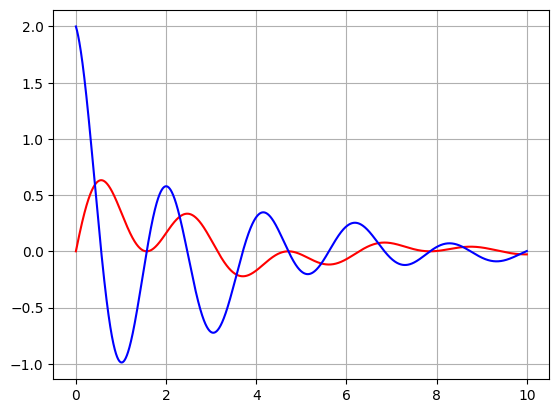

In [ ]:
x = tc.linspace(0, 10, 10000)
fig, ax = plot_func_and_deriv(x, f)

### Step 4. Torch의 자동미분을 이용한 경사하강법

#### 경사하강법 코드 수정하기 (1)

자동미분을 이용하면 경사하강법을 쉽게 구현할 수 있다. 연습을 위해 간단한 일변수 함수에 대해 경사하강법을 수행해볼 것이다. 앞선 예제에서도 다룬적 있는 함수 $\mathscr{L}(w) = w^2$에 대한 경사하강법을 수행하며 자동미분을 잘 활용해보자.

앞선 예제에서는 $\mathscr{L}(w) = w^2$의 도함수가 $\frac{d \mathscr{L}}{d w} = 2w$임을 알고 있는 상태에서 경사하강법 함수 descent_down_parabola()를 작성해보았다.

```python
def descent_down_parabola(w_start, learning_rate, num_steps):
    w_values = [w_start]
    for _ in range(num_steps):
        w_old = w_values[-1]
        w_new = w_old - learning_rate * (2 * w_old)
        w_values.append(w_new)
    return np.array(w_values)
```

이번에는 도함수를 모르는 $\mathscr{L}(w)$에 대해서도 적용할 수 있는, 자동미분을 이용한 경사하강법 함수를 작성해보자. $w$의 값을 PyTorch 텐서로 저장한 후, $\mathscr{L}(w)$를 $w$의 식으로 정의해주어, .backward() 메서드를 사용하여 편미분계수를 구할 수 있다.

아래의 경사하강법 공식에 따라 자동미분을 이용한 경사하강법을 프로그래밍으로 구현해보자.

\begin{equation}
w_{\mathrm{new}} = w_{\mathrm{old}} - \delta \frac{\mathrm{d}\mathscr{L}}{\mathrm{d}w}\big|_{w_{\mathrm{old}}}
\end{equation}

다음과 같이 $w$의 시작점과 학습률 $\delta$, 몇 단계 반복할 것인지가 주어졌다고 하자.

In [ ]:
w = tc.tensor([10.0], requires_grad=True)
learning_rate = 0.3
num_steps = 20 # epoch

이러한 상황에 대해 아래의 코드를 채워 경사하강법을 수행하는 코드를 작성해보자. 제대로 코드를 작성한다면, 다음과 같이 $w=0$으로 서서히 가까워지는 결과가 출력될 것이다.
```
Tensor(4.)
Tensor(1.6)
Tensor(0.64)
Tensor(0.256)
Tensor(0.1024)
```

In [ ]:
for _ in range(num_steps):
    ℒ = w ** 2 # w를 0에 최대한 가깝게 만들어줘야함
    ℒ.backward()
    # 여기에 코드 작성

    #  블록 안에서 w를 업데이트. 이는 PyTorch가 이 블록 내의 연산을 추적하지 않도록 한다.
    #  pytorch가 계산 그래프를 생성하지 않도록 함 => 불필요한 메모리 사용 억제
    with tc.no_grad():
        w -= learning_rate * w.grad
    #w의 그래디언트를 초기화. 이를 통해 다음 단계에서 그래디언트가 누적되지 않도록 한다.
    w.grad = None

    print(w)

tensor([4.], requires_grad=True)
tensor([1.6000], requires_grad=True)
tensor([0.6400], requires_grad=True)
tensor([0.2560], requires_grad=True)
tensor([0.1024], requires_grad=True)
tensor([0.0410], requires_grad=True)
tensor([0.0164], requires_grad=True)
tensor([0.0066], requires_grad=True)
tensor([0.0026], requires_grad=True)
tensor([0.0010], requires_grad=True)
tensor([0.0004], requires_grad=True)
tensor([0.0002], requires_grad=True)
tensor([6.7109e-05], requires_grad=True)
tensor([2.6844e-05], requires_grad=True)
tensor([1.0737e-05], requires_grad=True)
tensor([4.2950e-06], requires_grad=True)
tensor([1.7180e-06], requires_grad=True)
tensor([6.8719e-07], requires_grad=True)
tensor([2.7488e-07], requires_grad=True)
tensor([1.0995e-07], requires_grad=True)


그런데 코드를 작성할 때, 한가지 생각해볼만한 부분이 있다. 위의 코드를 완성하여 원하는 출력값도 제대로 얻었다면, 아래의 두 코드와 자신의 답변을 비교해보자. 꼭 먼저 코드를 직접 작성해본 후에 답변을 확인하길 바란다.

다음의 두 코드는 모두 원하는 출력값을 얻게 해주는 코드이다.
첫번째 코드는 다음과 같다.
```python
w = w - learning_rate * w.grad
```
두번째 코드는 다음과 같다.
```python
w.data -= learning_rate * w.grad
```

두 코드는 동일한 출력값을 얻게 해줄 뿐 아니라, 사실상 같은 의미라고 느껴진다. 그리고 첫번째 코드가 우리가 알고 있는 공식에 더 가까원 형태이기 때문에 좀 더 직관적이다. 그러나, 두번째 코드는 두가지 이점이 있다.

첫째로 컴퓨터 계산 속도를 최적화할 수 있다. 앞서 PyTorch의 텐서는 NumPy 배열의 수학적 연산들을 추적하는 추가 기능을 갖고 있는 객체라는 것을 배웠다. 그러나 이렇게 수학 연산을 추적하는 과정이 w 값을 갱신하는 과정에서는 굳이 필요하지 않다. 따라서 첫번째 코드와 같이 텐서를 사용하면, 불필요한 수학 연산의 추적으로 인해 간접적인 연산 처리 시간인 오버헤드(overhead)만 발생한다. 그러나 두번째 코드에서는 직접 텐서의 데이터를 업데이트함으로써, 불필요한 연산 그래프 추적을 피한다.

둘째로 추가적인 메모리 공간을 필요로 하지 않는다. 연산자 '-='는 증강 업데이트(augmented update)를 실행하는 연산자이다. 이는 컴퓨터가 새로운 메모리 공간을 할당하여 배열의 값을 교체하는 대신, 사용하던 메모리 공간을 그대로 다시 덮어쓰는 것을 의미한다. 따라서 기존 메모리 공간을 그대로 사용하므로, 메모리 사용이 최적화된다.

조만간 신경망에 대해 배운 후, 어렵고 복잡한 수학적 함수의 파라미터를 조정하게 되면, 수많은 대규모 데이터를 업데이트하게 될 것이다. 이런 상황에서 위의 두가지 이점은 학습의 성능에 큰 차이를 만들 것이다.

#### 경사하강법 코드 수정하기 (2)

이번에는 앞선 예제에서 다룬적 있는 이변수 함수 $\mathscr{L}(w_1, w_2) = 2w_1^2 + 3w_2^2$에 대한 경사하강법을 수행하며 자동미분을 잘 활용해보자.

앞선 예제에서는 $\mathscr{L}(w) = w^2$의 도함수가 $\frac{d \mathscr{L}}{d w} = 2w$임을 알고 있는 상태에서 경사하강법 함수 descent_down_2d_parabola()를 작성해보았다.

```python
def descent_down_2d_parabola(w_start, learning_rate, num_steps):
    xy_values = [w_start]
    for _ in range(num_steps):
        xy_old = xy_values[-1]
        xy_new = xy_old - learning_rate * (np.array([4., 6.]) * xy_old)
        xy_values.append(xy_new)
    return np.array(xy_values)
```

이번에는 도함수를 모르는 $\mathscr{L}(w_1, w_2)$에 대해서도 적용할 수 있는, 자동미분을 이용한 경사하강법 함수를 작성해보자. 다차원 텐서로 정의된 함수의 자동미분을 잘 떠올리면 해결하는 데 도움이 될 것이다.

다음과 같이 $\rm\textbf w$의 시작점과 학습률 $\delta$, 몇 단계 반복할 것인지가 주어졌다고 하자.

In [ ]:
w = tc.tensor([2., 4.], requires_grad=True)
learning_rate = 0.1
num_steps = 30

이러한 상황에 대해 아래의 코드를 채워 경사하강법을 수행하는 코드를 작성해보자. 제대로 코드를 작성한다면, 다음과 같이 $w_1=0, w_2=0$으로 서서히 가까워지는 결과가 출력될 것이다.
```
Tensor([1.2, 1.6])
Tensor([0.72, 0.64])
Tensor([0.432, 0.256])
Tensor([0.2592, 0.1024])
Tensor([0.15552, 0.04096])
```

In [ ]:
const = tc.tensor([2.0, 3.0])
for _ in range(num_steps):
    ℒ = const * w ** 2
    ℒ.sum().backward()
    # 여기에 코드 작성

    # w 업데이트 (메모리 최적화)
    with tc.no_grad():
        w -= learning_rate * w.grad

    # w 값 출력
    print(w)

    # 그래디언트 초기화
    w.grad.zero_()

tensor([1.2000, 1.6000], requires_grad=True)
tensor([0.7200, 0.6400], requires_grad=True)
tensor([0.4320, 0.2560], requires_grad=True)
tensor([0.2592, 0.1024], requires_grad=True)
tensor([0.1555, 0.0410], requires_grad=True)
tensor([0.0933, 0.0164], requires_grad=True)
tensor([0.0560, 0.0066], requires_grad=True)
tensor([0.0336, 0.0026], requires_grad=True)
tensor([0.0202, 0.0010], requires_grad=True)
tensor([0.0121, 0.0004], requires_grad=True)
tensor([0.0073, 0.0002], requires_grad=True)
tensor([4.3536e-03, 6.7109e-05], requires_grad=True)
tensor([2.6121e-03, 2.6844e-05], requires_grad=True)
tensor([1.5673e-03, 1.0737e-05], requires_grad=True)
tensor([9.4037e-04, 4.2950e-06], requires_grad=True)
tensor([5.6422e-04, 1.7180e-06], requires_grad=True)
tensor([3.3853e-04, 6.8719e-07], requires_grad=True)
tensor([2.0312e-04, 2.7488e-07], requires_grad=True)
tensor([1.2187e-04, 1.0995e-07], requires_grad=True)
tensor([7.3123e-05, 4.3980e-08], requires_grad=True)
tensor([4.3874e-05, 1.7592e-

#### 일반적인 경사하강법 함수 작성하기

일변수 함수, 다변수 함수에 대해 경사하강법을 수행해보았으니, 보편적인 상황에 대해 적용할 수 있는 일반적인 경사하강법 함수를 작성하는 것만 남았다.

<문제: 일반적인 경사하강법 함수 작성하기>

이 문제의 목표는 어떤 함수가 어떤 텐서로 정의되어 있는지에 상관없이 사용할 수 있는 경사하강법 함수를 작성하는 것이다. 함수 외부에서 텐서와 텐서들로 정의된 함수를 모두 정의한 후, .backward() 메서드까지 실행한다. 함수 내부로는 텐서들만 전달해주어, 함수 내에서는 그 텐서들을 이용하여 경사하강법을 실행한다.

아래 함수의 주석을 잘 보고, 일반적인 경사하강법 함수를 작성해보자. 주석을 보면 이 함수는 단일 텐서를 인자로 입력받을 수도 있지만, 여러개의 텐서로 이루어진 iterable한 객체를 입력받을 수도 있다. 어떻게 코딩해야 할지 막막한 느낌이 든다면, 다음 힌트를 살펴보자.

> HINT
> 1. 여러 개의 텐서로 이루어진 iterable한 자료형이 들어올 수 있으므로, for문을 이용하여 텐서를 하나씩 꺼내며 경사하강하는 코드를 작성해야한다.
> 2. 단일 텐서가 들어오면 for문을 이용할 수 없으므로, 단일 텐서를 단일 텐서가 들어있는 리스트로 바꾸어주는 과정이 있어야 한다.

In [ ]:
def gradient_step(tensors, learning_rate):
    """
    경사하강법의 공식에 따라 gradient-step을 실행.

    매개변수 (Parameters)
    ----------
    tensors : Union[Tensor, Iterable[Tensors]]
        단일 텐서, 혹은 텐서로 이루어진 iterable(리스트, 튜플 등) 모두 가능
        만약 특정 tensor에 대한 `tensor.grad`가 `None`인 경우, 업데이트를 건너 뜀

    learning_rate : float
        매 gradient-step에서의 학습률. 양수

    참고
    -----
    함수에서 진행되는 모든 gradient-steps는 tensor 내에서 바로 반영되므로, 반환 값 없음
    """
    # isinstance 함수를 이용하여 입력된 tensors가 단일 텐서인지, iterable인지 판단한다
    # tensor의 크기에 관계없이 항상 작동하게

    if isinstance(tensors, tc.Tensor):
        # Only one tensor was provided. Pack
        # it into a list so it can be accessed via
        # iteration
        tensors = [tensors]
        # 단일텐서이면 한 번 감싸주어야 반복문 실행 가능

    # for 문을 이용하여 tensors의 tensor를 하나씩 꺼내며 경사하강을 진행
    for t in tensors:
      if t.grad is not None:
        t.data -= learning_rate * t.grad
        t.grad.zero_() # 초기화

앞서 수행했던 함수 $\mathscr{L}(w) = w^2$에 대한 경사하강법을 다시 한번 실행해봄으로써 보편적인 경사하강법 함수가 우리가 원하는대로 동작하는지 확인해보자.

In [ ]:
w = tc.tensor(10.0, requires_grad=True)
learning_rate = 0.3
num_steps = 5

In [ ]:
for _ in range(num_steps):
    ℒ = w ** 2
    ℒ.backward()
    gradient_step(w, learning_rate = learning_rate)
    print(w)

tensor(4., requires_grad=True)
tensor(1.6000, requires_grad=True)
tensor(0.6400, requires_grad=True)
tensor(0.2560, requires_grad=True)
tensor(0.1024, requires_grad=True)


### 배운 내용 되돌아보기

이번 실습에서는 자동미분을 도와주는 PyTorch 라이브러리의 사용법을 배우고 익혔다. PyTorch는 앞으로의 거의 모든 실습에서 사용되는 중요한 라이브러리이다.

- Tensor를 생성하는 여러 가지 함수들을 사용해보았다. 원소를 직접 적어줄 수도 있고, 리스트, 튜플, NumPy의 ndarray 등으로부터 Tensor를 생성할 수도 있었다.

- 기존에 생성된 Tensor의 행과 열을 자유자재로 바꾸거나 일부 행이나 열만 슬라이싱 해보았다.

- PyTorch에서 제공하는 다양한 수학 연산 함수들을 사용해보았다. 그 과정에서 NumPy의 함수들과의 유사성을 확인하였다.

- 선형대수 연산을 돕는 함수인 matmul()과 einsum()을 사용해보았다.

- PyTorch에 딥러닝을 위한 특수 함수들이 다양하게 존재함을 알게 되었으나, 사용해보지는 않았다.

- PyTorch 텐서 객체의 .backward() 메서드를 사용하여 자동미분을 실행하고, 텐서의 .grad 속성을 이용하여 편미분 계수를 구해보았다.

- 경사하강을 반복하며 최적의 모델을 찾아갈 때, 경사하강이 1회 종료될 때마다 기존의 편미분 계수를 폐기해주어야 함을 알게 되었다. 이를 위해 .grad 속성을 폐기하는 방법을 직접 사용해보았다.

- PyTorch 텐서와 NumPy의 배열 사이의 관계를 알게 되었다.

- 불필요한 편미분 계수를 계산하는 것을 방지하기 위해, 텐서를 상수 취급하는 방법을 도입해야 함을 알게 되었다. 그리고 텐서를 상수 취급하기 위한 방법을 사용해보았다.

- 다차원 텐서에 대해 정의된 함수 (다변수 함수)에서 자동미분을 실행하면 다차원 텐서의 각 원소가 스칼라 값 변수로 해석되어 자동미분이 이루어짐을 알게 되었다. 또한 다차원 텐서의 .grad 속성에 함수의 그래디언트 값이 저장됨을 확인하였다.

- 다변수 벡터 함수에 대해 자동미분을 실행하면 모든 성분함수를 합한 것에 대해 자동미분이 이루어짐을 알게 되었다. 또한 이런 규칙이 어떤 유용함을 가지는지 확인하였다.

- PyTorch의 자동미분을 이용하여 경사하강법 함수를 새롭게 구현해보았다.